In [181]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [182]:
train_range = 150
test_range = 50

In [183]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [184]:
class CSVDataset(torch.utils.data.Dataset):
    """ Diabetes dataset."""

    # Initialize your data, download, etc.
    def __init__(self):
        xy = np.loadtxt('/content/gdrive/MyDrive/present_train_250.csv',
                        delimiter=',', dtype=np.float32)
        self.len = train_range
        print(xy.shape)
        self.x_data = torch.from_numpy(xy[:train_range, 1:17])
        self.y_data = torch.from_numpy(xy[:train_range, 0])
        print((self.x_data.shape))
        #print(self.y_data)
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


dataset = CSVDataset()
train_loader = torch.utils.data.DataLoader(dataset=dataset,
                          batch_size=8,
                          shuffle=False,
                            drop_last = True)

(250, 17)
torch.Size([250, 16])


In [185]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.conv1 = nn.Conv2d(1, 6, kernel_size=1)
        #self.conv2 = nn.Conv2d(6, 16, kernel_size=1)
        self.input = nn.Linear(16, 64)
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)
        #self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.input(x))
        #x = F.max_pool2d(x, 2)
        #x = F.relu(self.conv2(x))
        #x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        #x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        x = torch.sigmoid(x)
        
        #print(x)
        return x  #torch.cat((x, 1 - x), -1)

In [186]:
import time

In [187]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.BCELoss()
#loss_func = nn.CrossEntropyLoss()
#loss_func = nn.NLLLoss()

epochs = 20
loss_list = []
model.train()
ts = time.time()

for epoch in range(epochs):
    total_loss = []
    for batch_idx, x in enumerate(train_loader):
        data, target = x
        target = target.unsqueeze(1)
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        #target = target.long()
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    
    te = time.time()

    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))
    print('runtime: {:2.2f}sec'.format(te-ts))

Training [5%]	Loss: 0.6956
runtime: 0.04sec
Training [10%]	Loss: 0.6920
runtime: 0.08sec
Training [15%]	Loss: 0.6863
runtime: 0.11sec
Training [20%]	Loss: 0.6819
runtime: 0.16sec
Training [25%]	Loss: 0.6735
runtime: 0.19sec
Training [30%]	Loss: 0.6620
runtime: 0.24sec
Training [35%]	Loss: 0.6496
runtime: 0.28sec
Training [40%]	Loss: 0.6400
runtime: 0.33sec
Training [45%]	Loss: 0.6237
runtime: 0.37sec
Training [50%]	Loss: 0.6096
runtime: 0.41sec
Training [55%]	Loss: 0.5932
runtime: 0.44sec
Training [60%]	Loss: 0.5776
runtime: 0.49sec
Training [65%]	Loss: 0.5678
runtime: 0.53sec
Training [70%]	Loss: 0.5541
runtime: 0.57sec
Training [75%]	Loss: 0.5585
runtime: 0.61sec
Training [80%]	Loss: 0.5318
runtime: 0.66sec
Training [85%]	Loss: 0.5208
runtime: 0.70sec
Training [90%]	Loss: 0.4979
runtime: 0.74sec
Training [95%]	Loss: 0.4934
runtime: 0.79sec
Training [100%]	Loss: 0.4598
runtime: 0.83sec


Text(0, 0.5, 'Neg Log Likelihood Loss')

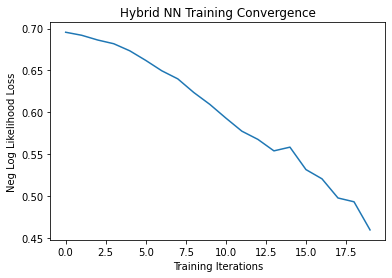

In [188]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [189]:
class CSVDataset(torch.utils.data.Dataset):
    """ Diabetes dataset."""

    # Initialize your data, download, etc.
    def __init__(self):
        xy = np.loadtxt('/content/gdrive/MyDrive/present_test_50.csv',
                        delimiter=',', dtype=np.float32)
        self.len = test_range
        self.x_data = torch.from_numpy(xy[:test_range, 1:17])
        self.y_data = torch.from_numpy(xy[:test_range, 0])

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


dataset = CSVDataset()
test_loader = torch.utils.data.DataLoader(dataset=dataset,
                          batch_size=8,
                          shuffle=False,
                            drop_last=True)

In [190]:
import math
model.eval()
with torch.no_grad():
    
    correct = 0

    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        pred = output
        target = target.unsqueeze(1)
        for i in range(8):
            if (output[i] > 0.5):
                pred[i] = math.ceil(output[i])
            else:
                pred[i] = math.floor(output[i])
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss = loss_func(output, target)
        total_loss.append(loss.item())
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(dataset) * 100)
        )

Performance on test data:
	Loss: 7.4799
	Accuracy: 54.0%
